# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [1]:
!git clone https://github.com/IdePHICS/FundamentalLearningEPFL.git

Cloning into 'FundamentalLearningEPFL'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 197 (delta 31), reused 30 (delta 21), pack-reused 124 (from 2)
Receiving objects: 100% (197/197), 31.24 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
import sys
sys.path.append('/content/FundamentalLearningEPFL/TP10/')
import training_utils

In [3]:
import importlib, types
imp = types.ModuleType("imp")
imp.reload = importlib.reload
sys.modules["imp"] = imp

%load_ext autoreload
%autoreload 2

In [4]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [6]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.2MB/s]


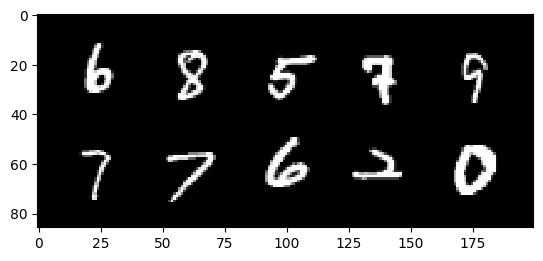

In [7]:
visualize_images(train_dataloader)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [9]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.4398916656688108
Epoch 1: Loss=0.43409352837982823
Epoch 2: Loss=0.25713952340311924
Epoch 3: Loss=0.20274927378711055
Epoch 4: Loss=0.17085361884812178
Epoch 5: Loss=0.14601699439650875
Epoch 6: Loss=0.13172324746847153
Epoch 7: Loss=0.11723771413504067
Epoch 8: Loss=0.10940255578291619
Epoch 9: Loss=0.10047389061774238
Test set: Avg. loss: 0.0830, Accuracy: 9746/10000 (97%)


(0.08295016860961914, tensor(97.4600, device='cuda:0'))

## CIFAR10

In [10]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


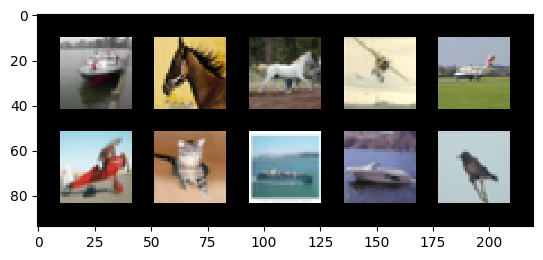

In [11]:
visualize_images(train_dataloader)

In [12]:
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, #COLORED IMAGES!
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10) #Now is 32x32 images!

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn_cifar,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=2.2287964820861816
Epoch 1: Loss=2.109368776788517
Epoch 2: Loss=1.990474491703267
Epoch 3: Loss=1.8699571405138289
Epoch 4: Loss=1.7731556868066594
Epoch 5: Loss=1.6944097402144451
Epoch 6: Loss=1.6268513275652516
Epoch 7: Loss=1.5695862964707978
Epoch 8: Loss=1.5319723499064544
Epoch 9: Loss=1.492152398946334
Test set: Avg. loss: 1.4719, Accuracy: 4715/10000 (47%)


(1.4719047241210939, tensor(47.1500, device='cuda:0'))

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [13]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [14]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Let's modify the fit function to also use a validation set.

In [15]:
from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

### Learning rate
**Question** Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

**Question** Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitatively) what happens.

### Optimizer

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



**Question** Implement momentum and compute the learning curve. How does this change affect performance?

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perform a grid search; define a list of choices for each hyperparameter and search over all combinations.


**Question** Perform a grid search over the learning rate and batch size. What is the best combination?

# Part 2

On the previous part we implemented CNNs using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings works out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this part, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline.

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

So... let's get started!


In [16]:
# first we load all the necessary libraries

import torchvision.transforms as transforms
import torch.nn.functional as F

In [17]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)


In [18]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


## Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. What does BatchNorm actually do?

Suppose we are given values of $x$ over a mini-batch $B=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

- First, we compute the mini-batch mean
    $$
    \mu_{B}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
and mini-batch variance
    $$
    \sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{B})^2
    $$
- we use these quantities to normalize our input
    $$
    x_i\leftarrow\frac{x_i-\mu_{B}}{\sqrt{\sigma^2_{B}+\epsilon}}
    $$
- We scale, shift and return the output
    $$
    y_i=\gamma x_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 50000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent.
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



Let's redo the previous cnn architecture with batch normalization.
Observe where the batch normalization goes.

In [19]:
class CNNwithBN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

Epoch 0: Train Loss=1.5781
Epoch 1: Train Loss=1.1750
Epoch 2: Train Loss=1.0367
Epoch 3: Train Loss=0.9446
Epoch 4: Train Loss=0.8950
Epoch 5: Train Loss=0.8434
Epoch 6: Train Loss=0.8171
Epoch 7: Train Loss=0.7931
Epoch 8: Train Loss=0.7727
Epoch 9: Train Loss=0.7439
Epoch 10: Train Loss=0.7191
Epoch 11: Train Loss=0.7168
Epoch 12: Train Loss=0.7045
Epoch 13: Train Loss=0.6842
Epoch 14: Train Loss=0.6857
Epoch 15: Train Loss=0.6643
Epoch 16: Train Loss=0.6498
Epoch 17: Train Loss=0.6460
Epoch 18: Train Loss=0.6373
Epoch 19: Train Loss=0.6319
Epoch 20: Train Loss=0.6196
Epoch 21: Train Loss=0.6051
Epoch 22: Train Loss=0.6002
Epoch 23: Train Loss=0.5930
Epoch 24: Train Loss=0.5970
Epoch 25: Train Loss=0.5908
Epoch 26: Train Loss=0.5893
Epoch 27: Train Loss=0.5761
Epoch 28: Train Loss=0.5720
Epoch 29: Train Loss=0.5646
Test set: Avg. loss: 1.0794, Accuracy: 6745/10000 (67%)


(1.0793921752929687, tensor(67.4500, device='cuda:0'))

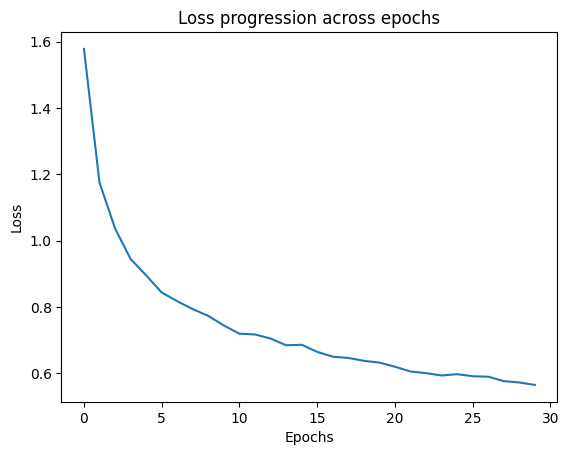

In [20]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

**Question** One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster?


In [21]:
# YOUR CODE HERE

## Learning rate scheduler

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and we start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In the following cell, we augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

In [22]:
from training_utils import train_epoch

def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None
):
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

        if scheduler is not None:
            scheduler.step()

    return losses

Now we train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

In [ ]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[25, 30],
    gamma=0.1,
)


losses =   fit_scheduler(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE,
        scheduler=scheduler,
)

plot_loss(losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


Epoch 0: Loss=2.2841565438679288
Epoch 1: Loss=1.4611294829115575
Epoch 2: Loss=1.340674911226545
Epoch 3: Loss=1.2608290205196457
Epoch 4: Loss=1.1942832932180287
Epoch 5: Loss=1.1510997061826744
Epoch 6: Loss=1.109543581398166
Epoch 7: Loss=1.06986604053147
Epoch 8: Loss=1.030179897133185
Epoch 9: Loss=1.005446543498915
Epoch 10: Loss=0.9756737035147998
Epoch 11: Loss=0.9621615555821633
Epoch 12: Loss=0.933709340436118
Epoch 13: Loss=0.9156729834420341
Epoch 14: Loss=0.913380639893668
Epoch 15: Loss=0.8908742118854912
Epoch 16: Loss=0.8837900113086311
Epoch 17: Loss=0.868869816770359
Epoch 18: Loss=0.8582681356644144
Epoch 19: Loss=0.8492910302415186


## Residual connections

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth.

![caption](https://github.com/YDIB11/FundamentalLearningEPFL/blob/main/TP10/media/resnet-no-skip-horizontal.png?raw=1)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence.

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](https://github.com/YDIB11/FundamentalLearningEPFL/blob/main/TP10/media/resnet-horizontal.png?raw=1)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512.

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [ ]:
class NonResidualBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [ ]:
# initialize the model
model = ResNet(block=NonResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )


In [ ]:

plot_loss(train_losses)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Evaluated part:

Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm.

**Question** Fill the code below and train the network!

In [ ]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        # YOUR CODE GOES HERE

In [ ]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )
plot_loss( train_losses )

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)

**Question:** It looks like the model without the residual connections performs better (3-4%), but on a closer examination of the training curves the residual model achieves lower loss much faster and then plateaus. You might try to add a scheduler to boost the performance!